In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as ss

# Linear regression model for predicting output ratio of metals
We start by looking at the correlation between selected parameters

In [3]:
df7=pd.read_pickle("Data/df7.pickle")
df7.columns = df7.columns.str.strip()\
                         .str.lower()\
                         .str.replace('+','')\
                         .str.replace('^','')\
                         .str.replace(' ', '_')\
                         .str.replace('[', '')\
                         .str.replace(']', '')\
                         .str.replace('/', '')\
                         .str.replace('_mgl','')

df7.columns = df7.columns.str.replace('salinity_gl','s')\
                         .str.replace('temperature','t')
df7[['mg','ca','li_outin_ratio','al_outin_ratio','ph','s','ewe','t']].corr().style.background_gradient().set_precision(2)

,mg,ca,li_outin_ratio,al_outin_ratio,ph,s,ewe,t
mg,1.00,0.01,-0.13,0.15,0.00,-0.08,-0.10,-0.07
ca,0.01,1.00,0.29,0.09,0.00,-0.07,-0.09,-0.06
li_outin_ratio,-0.13,0.29,1.00,-0.04,0.14,0.29,-0.03,-0.05
al_outin_ratio,0.15,0.09,-0.04,1.00,-0.53,-0.16,-0.06,-0.11
ph,0.00,0.00,0.14,-0.53,1.00,-0.00,0.00,0.00
s,-0.08,-0.07,0.29,-0.16,-0.00,1.00,-0.07,-0.05
ewe,-0.10,-0.09,-0.03,-0.06,0.00,-0.07,1.00,-0.06
t,-0.07,-0.06,-0.05,-0.11,0.00,-0.05,-0.06,1.00


In [4]:
df7.head()

,ph,al,li,ca,mg,al_outin_ratio,li_outin_ratio,energy_input_kwhm3,energy_input_kwhkg_metal_rem.,t,s,ewe,ca__mg
0,7,155.9,0,0,0,1.000000,0.000000,0.13,31.75,20,30,0.35,0
1,7,155.9,20,0,0,0.991736,0.090909,1.61,10.50,20,30,0.35,0
2,7,155.9,40,0,0,0.995868,0.119835,1.63,10.10,20,30,0.35,0
3,7,155.9,80,0,0,0.842975,0.123967,1.63,10.11,20,30,0.35,0
4,9,155.9,0,0,0,1.000000,0.000000,0.13,31.75,20,30,0.35,0


In [5]:
epsLi=5e-3
LiMax=0.4
df7['li_outin_ratio_logit']=np.where(df7['li_outin_ratio']<epsLi,
                                     np.log((df7['li_outin_ratio']+epsLi)/(LiMax-df7['li_outin_ratio']-epsLi)),
                                     np.log(df7['li_outin_ratio']/(LiMax-df7['li_outin_ratio']))
                                     )
epsAl=2e-2
df7['al_outin_ratio_logit']=np.where(df7['al_outin_ratio']==1.0,
                                     np.log((df7['al_outin_ratio']-epsAl)/(1.0-df7['al_outin_ratio']+epsAl)),
                                     np.log(df7['al_outin_ratio']/(1.0-df7['al_outin_ratio']))
                                     )

In [6]:
df7.head()

,ph,al,li,ca,mg,al_outin_ratio,li_outin_ratio,energy_input_kwhm3,energy_input_kwhkg_metal_rem.,t,s,ewe,ca__mg,li_outin_ratio_logit,al_outin_ratio_logit
0,7,155.9,0,0,0,1.000000,0.000000,0.13,31.75,20,30,0.35,0,-4.369448,3.891820
1,7,155.9,20,0,0,0.991736,0.090909,1.61,10.50,20,30,0.35,0,-1.223775,4.787492
2,7,155.9,40,0,0,0.995868,0.119835,1.63,10.10,20,30,0.35,0,-0.849266,5.484797
3,7,155.9,80,0,0,0.842975,0.123967,1.63,10.11,20,30,0.35,0,-0.800506,1.680534
4,9,155.9,0,0,0,1.000000,0.000000,0.13,31.75,20,30,0.35,0,-4.369448,3.891820


In [17]:
#Features selected for the regression model
X=df7[['mg','ca','ph','s','t','ewe']]
X=X.fillna(0)
X=sm.add_constant(X)

#Labels selected for the regression model
YAl=df7['al_outin_ratio_logit']
YLi=df7['li_outin_ratio_logit']

#The aluminum extraction model fitted
estAl=sm.OLS(YAl,X)
estAl=estAl.fit()
#print(estAl.summary())

#The lithium extraction model fitted
estLi=sm.OLS(YLi,X)
estLi=estLi.fit()
#print(estLi.summary())

# Small code to automatically write the python directly from the linear regression results

In [18]:
import string
############################################################################################
print("def alOut0(P):")
out="    out="
for (x,y) in zip(string.ascii_uppercase[:len(X.columns)],X.columns):
    print("    "+x+"="+str(estAl.params[y])+"    #"+y)
    if y=='const':
        out=out+x+"+"   
    else:   
        out=out+x+"*P['"+y+"']+"
print(out[:-1])
print("    return 1.0/(1.0+np.exp(-out))")
        
print("def alOut(P):")
for (x,y) in zip(string.ascii_uppercase[:len(X.columns)],X.columns):
    print("    "+x+"=np.random.normal("+str(estAl.params[y])+","+str(estAl.bse[y])+")    #"+y)

print(out[:-1])
print("    return 1.0/(1.0+np.exp(-out))")
############################################################################################
print("def liOut0(P):")
out="    out="
for (x,y) in zip(string.ascii_uppercase[:len(X.columns)],X.columns):
    print("    "+x+"="+str(estLi.params[y])+"    #"+y)
    if y=='const':
        out=out+x+"+"   
    else:   
        out=out+x+"*P['"+y+"']+"
print(out[:-1])
print("    return "+str(LiMax)+"/(1.0+np.exp(-out))")
        
print("def liOut(P):")
for (x,y) in zip(string.ascii_uppercase[:len(X.columns)],X.columns):
    print("    "+x+"=np.random.normal("+str(estLi.params[y])+","+str(estLi.bse[y])+"*"+str(0.4)+")    #"+y)

print(out[:-1])
print("    return "+str(LiMax)+"/(1.0+np.exp(-out))")

def alOut0(P):
    A=9.24311268356563    #const
    B=0.0007290528430428682    #mg
    C=2.376610882638268e-05    #ca
    D=-0.6104172351984469    #ph
    E=-0.010237634179299359    #s
    F=0.007754636032184951    #t
    G=-0.854752937441762    #ewe
    out=A+B*P[&#39;mg&#39;]+C*P[&#39;ca&#39;]+D*P[&#39;ph&#39;]+E*P[&#39;s&#39;]+F*P[&#39;t&#39;]+G*P[&#39;ewe&#39;]
    return 1.0/(1.0+np.exp(-out))
def alOut(P):
    A=np.random.normal(9.24311268356563,1.1734648994007995)    #const
    B=np.random.normal(0.0007290528430428682,0.0005482925615291151)    #mg
    C=np.random.normal(2.376610882638268e-05,4.982003931049446e-05)    #ca
    D=np.random.normal(-0.6104172351984469,0.09299424362214659)    #ph
    E=np.random.normal(-0.010237634179299359,0.006459516129063304)    #s
    F=np.random.normal(0.007754636032184951,0.02506832228179898)    #t
    G=np.random.normal(-0.854752937441762,1.1856402922543536)    #ewe
    out=A+B*P[&#39;mg&#39;]+C*P[&#39;ca&#39;]+D*P[&#39;ph&#39;]+E*P[&#39;s&#39;

In [19]:
def alOut0(P):
    A=9.24311268356563    #const
    B=0.0007290528430428423    #mg
    C=2.3766108826381164e-05    #ca
    D=-0.6104172351984468    #ph
    E=-0.010237634179299487    #s
    F=0.0077546360321851665    #t
    G=-0.8547529374417617    #ewe
    out=A+B*P['mg']+C*P['ca']+D*P['ph']+E*P['s']+F*P['t']+G*P['ewe']
    return 1.0/(1.0+np.exp(-out))
def alOut(P):
    A=np.random.normal(9.24311268356563,1.1734648994007995)    #const
    B=np.random.normal(0.0007290528430428423,0.0005482925615291163)    #mg
    C=np.random.normal(2.3766108826381164e-05,4.9820039310494476e-05)    #ca
    D=np.random.normal(-0.6104172351984468,0.09299424362214656)    #ph
    E=np.random.normal(-0.010237634179299487,0.006459516129063307)    #s
    F=np.random.normal(0.0077546360321851665,0.02506832228179895)    #t
    G=np.random.normal(-0.8547529374417617,1.1856402922543534)    #ewe
    out=A+B*P['mg']+C*P['ca']+D*P['ph']+E*P['s']+F*P['t']+G*P['ewe']
    return 1.0/(1.0+np.exp(-out))
def liOut0(P):
    A=-2.166550880352734    #const
    B=-0.0003854407076135767    #mg
    C=0.00012938450784227536    #ca
    D=0.1054253807914887    #ph
    E=0.01679336165131664    #s
    F=0.0005523783360058695    #t
    G=0.2139415368181169    #ewe
    out=A+B*P['mg']+C*P['ca']+D*P['ph']+E*P['s']+F*P['t']+G*P['ewe']
    return 0.4/(1.0+np.exp(-out))
def liOut(P):
    A=np.random.normal(-2.166550880352734,1.310114605685625*0.4)    #const
    B=np.random.normal(-0.0003854407076135767,0.0006121410989070697*0.4)    #mg
    C=np.random.normal(0.00012938450784227536,5.562157094757524e-05*0.4)    #ca
    D=np.random.normal(0.1054253807914887,0.10382340100353452*0.4)    #ph
    E=np.random.normal(0.01679336165131664,0.007211725234107112*0.4)    #s
    F=np.random.normal(0.0005523783360058695,0.02798752240326007*0.4)    #t
    G=np.random.normal(0.2139415368181169,1.323707820118836*0.4)    #ewe
    out=A+B*P['mg']+C*P['ca']+D*P['ph']+E*P['s']+F*P['t']+G*P['ewe']
    return 0.4/(1.0+np.exp(-out))

In [20]:
df7['al_outin_ratio_model']=df7.apply(lambda row: alOut0(row), axis=1)
df7[['al2p3','al15p9','al84p1','al97p7']]=df7.apply(lambda row: pd.Series(np.round(np.percentile([alOut(row) for i in range(1000)],[2.3,15.9,84.1,97.7]),1)),axis=1)
df7['al_model_error']=df7['al_outin_ratio_model']-df7['al_outin_ratio']

df7['li_outin_ratio_model']=df7.apply(lambda row: liOut0(row), axis=1)
df7[['li2p3','li15p9','li84p1','li97p7']]=df7.apply(lambda row: pd.Series(np.round(np.percentile([liOut(row) for i in range(1000)],[2.3,15.9,84.1,97.7]),1)),axis=1)
df7['li_model_error']=df7['li_outin_ratio_model']-df7['li_outin_ratio']


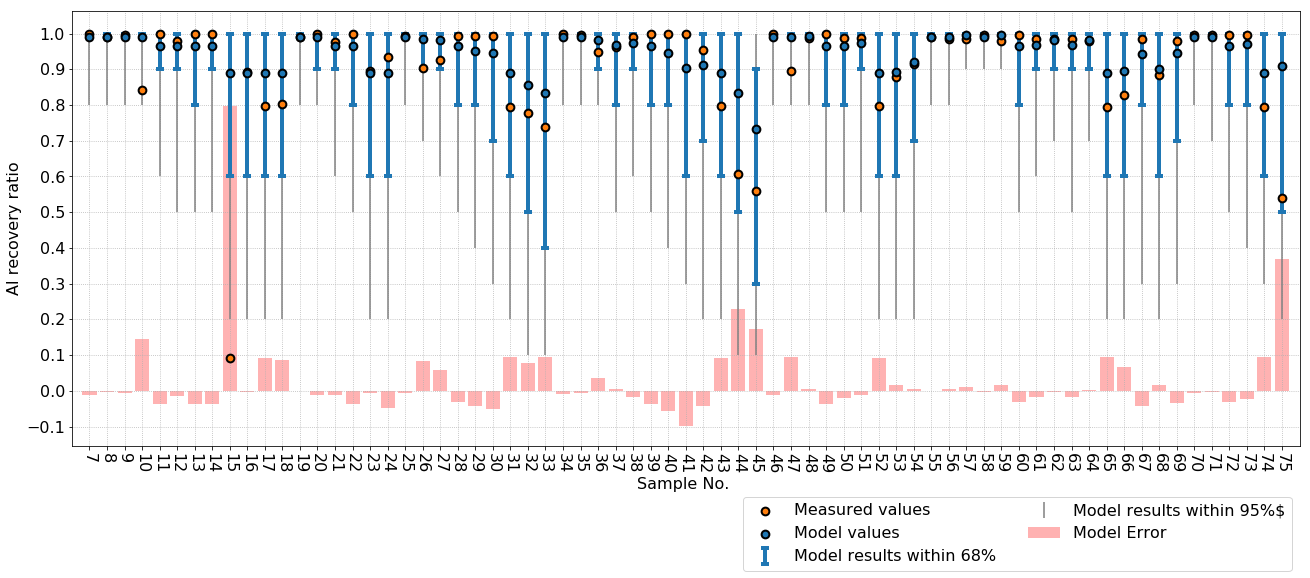

In [21]:
plt.rcParams.update({'font.size': 16})
fig,ax=plt.subplots(figsize=(22,8))


ax.errorbar(df7['al_outin_ratio_model'].index+7,
            df7['al_outin_ratio_model'].values,
            yerr=np.vstack([df7['al_outin_ratio_model'].values-df7['al15p9'].values,
                            df7['al84p1'].values-df7['al_outin_ratio_model'].values]),
            capsize=4,
            capthick=4,
            linewidth=4,
            fmt ='none',
            zorder=10,
            label='Model results within 68%')

ax.errorbar(df7['al_outin_ratio_model'].index+7,
            df7['al_outin_ratio_model'].values,
            yerr=np.vstack([df7['al_outin_ratio_model'].values-df7['al2p3'].values,
                            df7['al97p7'].values-df7['al_outin_ratio_model'].values]),
            capsize=0,
            capthick=1,
            color='gray',
            fmt ='none',
            zorder=5,
            label='Model results within 95%$')

#for origin in ['ENGLAND','ICELAND','BELGIUM','ROMANIA','LAB']:
#    subdf=dfAll[dfAll['brine_origin']==origin]
ax.scatter(df7.index+7, df7['al_outin_ratio'],color='C1',s=60,edgecolor='k',lw=2,zorder=20,label='Measured values')
ax.scatter(df7.index+7, df7['al_outin_ratio_model'],color='C0',s=60,edgecolor='k',lw=2,zorder=20,label='Model values')
ax.set_xticks([i+7 for i in range(len(df7))])
ax.set_xlim(6,len(df7)+7)
ax.set_yticks([i/10 for i in range(-1,11,1)])
ax.set_ylabel("Al recovery ratio")
ax.set_xlabel("Sample No. ")
plt.xticks(rotation=-90)
ax.grid(linestyle='dotted')
ax.bar(df7.index+7,df7['al_model_error'],color='red',alpha=0.3,zorder=0,label='Model Error')
ax.legend(ncol=2,bbox_to_anchor=(1, -0.1))
plt.savefig("GDEx_Al_Model.png", bbox_inches='tight')

In [22]:
print('Al model error:',df7['al_model_error'].min(),df7['al_model_error'].max(),df7['al_model_error'].median(),df7['al_model_error'].mean())

Al model error: -0.09768583928757346 0.7977704129164391 -0.004545597417195402 0.02912820997856493


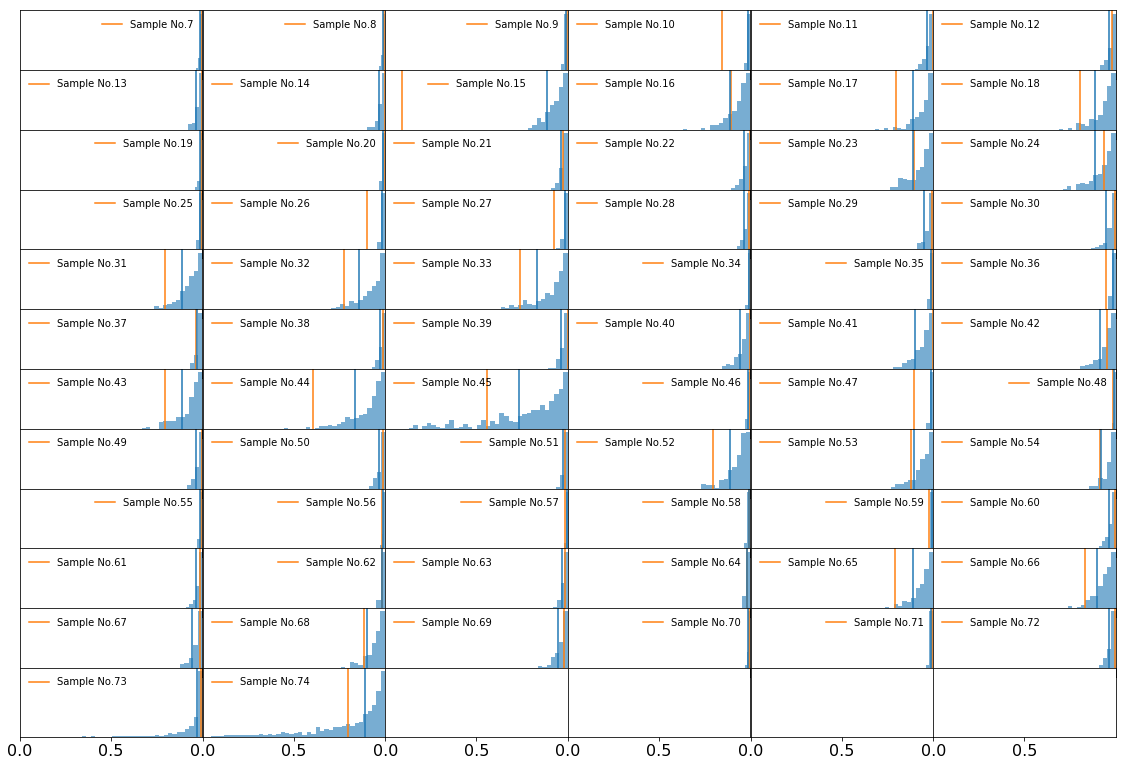

In [23]:
fig,ax=plt.subplots(12,6,figsize=(15,10),sharex=True)
for n in range(68):
    ax[n//6][n%6].hist([alOut(df7.iloc[n]) for i in range(1000)],40,label=None,alpha=0.6);
    ax[n//6][n%6].axvline(df7['al_outin_ratio'].iloc[n],color='C1',label='Sample No.'+str(n+7));
    ax[n//6][n%6].axvline(df7['al_outin_ratio_model'].iloc[n],color='C0',label=None);
    ax[n//6][n%6].legend(fontsize=10,frameon=False)
    
for n in range(12*6):
    ax[n//6][n%6].set_yticks([])
    ax[n//6][n%6].set_xlim(0,1)
    ax[n//6][n%6].set_xticks([0,0.5])

plt.tight_layout(pad=-1)
plt.savefig("GEDx_Al_Model_histograms.png", bbox_inches='tight')

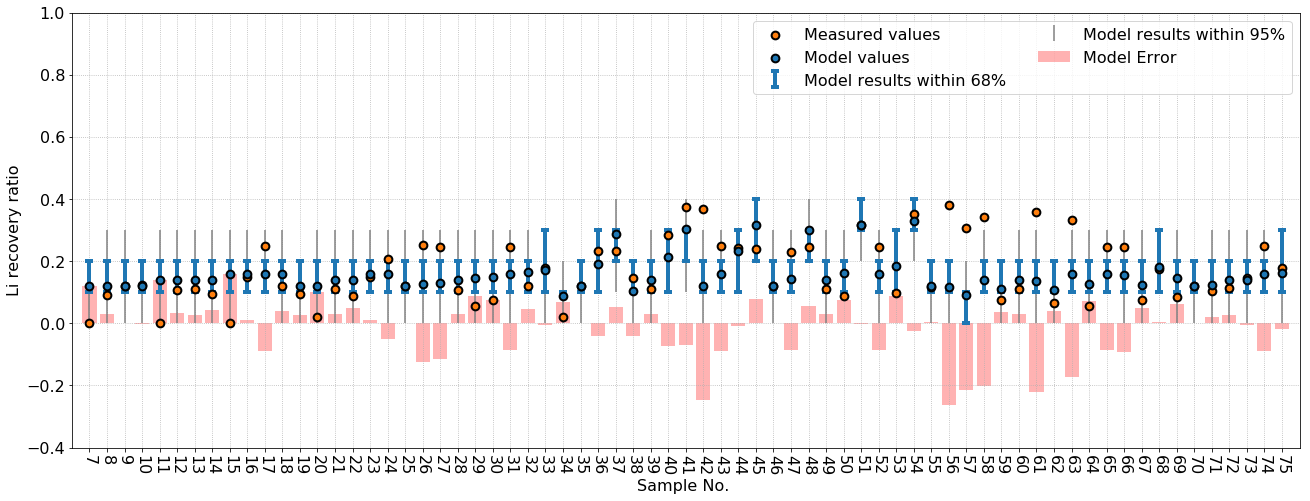

In [24]:
plt.rcParams.update({'font.size': 16})
fig,ax=plt.subplots(figsize=(22,8))

ax.errorbar(df7['li_outin_ratio_model'].index+7,
            df7['li_outin_ratio_model'].values,
            yerr=np.vstack([df7['li_outin_ratio_model'].values-df7['li15p9'].values,
                            df7['li84p1'].values-df7['li_outin_ratio_model'].values]),
            capsize=4,
            capthick=4,
            linewidth=4,
            fmt ='none',
            zorder=10,
            label='Model results within 68%')

ax.errorbar(df7['li_outin_ratio_model'].index+7,
            df7['li_outin_ratio_model'].values,
            yerr=np.vstack([df7['li_outin_ratio_model'].values-df7['li2p3'].values,
                            df7['li97p7'].values-df7['li_outin_ratio_model'].values]),
            capsize=0,
            capthick=1,
            color='gray',
            fmt ='none',
            zorder=5,
            label='Model results within 95%')

ax.scatter(df7.index+7, df7['li_outin_ratio'],color='C1',s=60,edgecolor='k',lw=2,zorder=20,label='Measured values')
ax.scatter(df7.index+7, df7['li_outin_ratio_model'],color='C0',s=60,edgecolor='k',lw=2,zorder=20,label='Model values')
ax.set_xticks(range(7,len(df7)+7))
ax.set_xlim(6,len(df7)+7)
ax.set_ylabel("Li recovery ratio")
ax.set_ylim([-0.4,1.0])
ax.set_xlabel("Sample No. ")
plt.xticks(rotation=-90)
ax.grid(linestyle='dotted')
ax.bar(df7.index+7,df7['li_model_error'],color='red',alpha=0.3,zorder=0,label='Model Error')
ax.legend(ncol=2)
plt.savefig("GDEx_Li_Model.png", bbox_inches='tight')

In [25]:
print('Li model error:',df7['li_model_error'].min(),df7['li_model_error'].max(),df7['li_model_error'].median(),df7['li_model_error'].mean())

Li model error: -0.2644219215255144 0.15888017211161856 0.005133327020452855 -0.010510284889516741


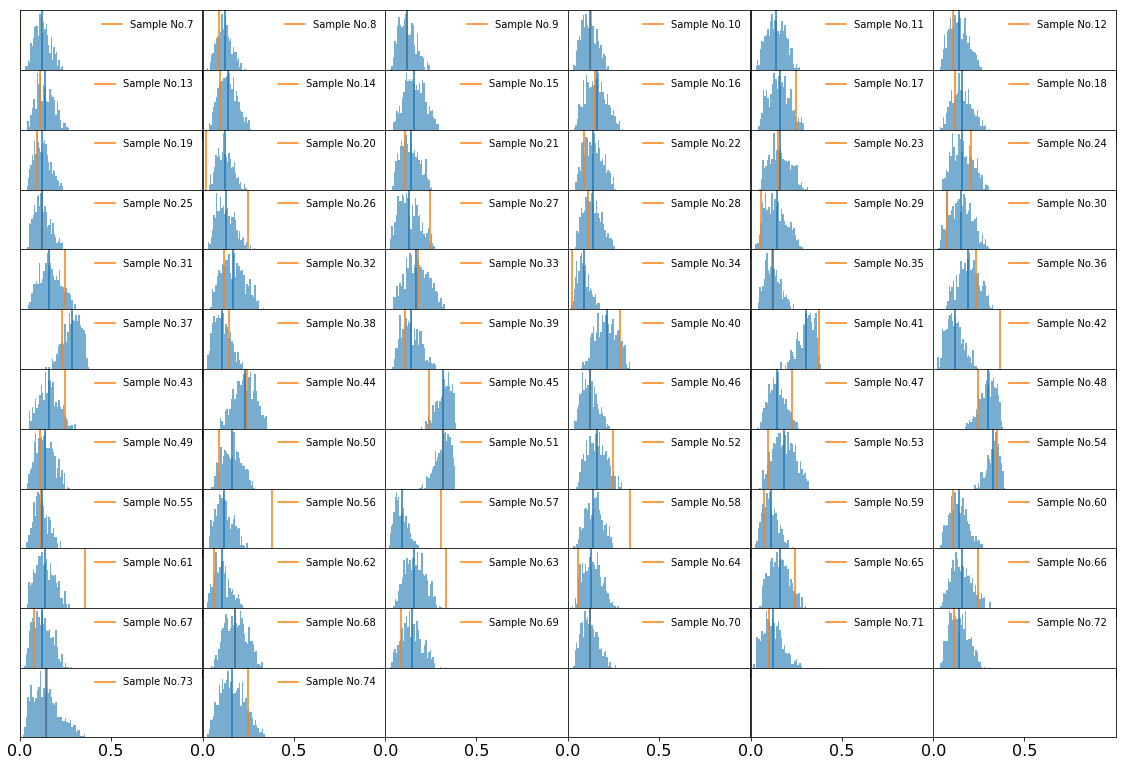

In [26]:
fig,ax=plt.subplots(12,6,figsize=(15,10),sharex=True)
for n in range(68):
    ax[n//6][n%6].hist([liOut(df7.iloc[n]) for i in range(1000)],40,label=None,alpha=0.6);
    ax[n//6][n%6].axvline(df7['li_outin_ratio'].iloc[n],color='C1',label='Sample No.'+str(n+7));
    ax[n//6][n%6].axvline(df7['li_outin_ratio_model'].iloc[n],color='C0',label=None);
    ax[n//6][n%6].legend(fontsize=10,frameon=False)
    
for n in range(12*6):
    ax[n//6][n%6].set_yticks([])
    ax[n//6][n%6].set_xlim(0,1)
    ax[n//6][n%6].set_xticks([0,0.5])

plt.tight_layout(pad=-1)
plt.savefig("GEDx_Li_Model_histograms.png", bbox_inches='tight')